# ARIMA(Auto Regressive Integrated Moving Average)

## Intro

ARIMA is an algorithm that uses past data to predict future data in time series. It is a combination of 3 models(autoregression, integrated, and moving-average) and is one of the most commonly used time series forecasting models. Some practical examples include predicting stock prices and sales figures.

## What does each part of the model do?

### AR(Autoregression)

We use this to forecast future values using a linear combination of the previously observed values.

#### $y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t$.

$y_t:$ is the prediction result at time t\
$c:$ is the constant term that represents the baseline value of $y_t$ when all lag terms are zero\
$\phi_i:$ is the autoregressive/lag coefficients that measures the effect of $y_{t-i}$ on $y_t$\
$y_{t-i}:$ are past observed values of y used to perdict $y_t$\
$\epsilon_t:$ is the error term at time t, represent the part of y that is unpredictable(random fluctuations)\
$p:$ is the number of lag components, also known as the order, which defines how far back the model looks

### I(Integrated)

Integration refers the differencing, the process of computing differences between consecutive observations to remove trends. If the time series is non-stationary(changing mean and variance over time), differencing helps stabilize it, since applying AR and MA requires stationarity. d is the number of order differencing is applied to make the time series stationary. We can determine d using tests like Augmented Dickey-Fuller (ADF) Test, where it checks if the p-value > 0.05 and if so it applies differencing, or Inspect Autocorrelation Function (ACF). Differencing often makes the time series have a constant mean after 1-2 operation, but test to make sure it's not under or over done.\
\
Note that we have to apply another transformation like Box-Cox or logarithmic to make the variance constant. To test for it, plot the data and observe the shape, or use statistical tests like Breusch-Pagan test for heteroskedasticity. Always apply the log transformation before differencing to prevent logging negative values.

### MA(Moving-average)

We use this to forecast future values using past forecast errors.

#### $y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}$.

$y_t:$ is the prediction result at time t\
$\mu:$ is the mean which is also the constant term that represents the baseline value of $y_t$ when all lag terms are zero. We use mean to emphasize this is the expected value, not just an arbitrary intercept\
$\epsilon_{t-i}:$ is the error term at time t, represent the part of y that is unpredictable(random fluctuations)\
$\theta_i:$ is the lag coefficients that measures the effect of $\epsilon_{t-i}$ on $\epsilon_t$\
$\epsilon_i:$ is the past error terms\
$q:$ is the number of lag components, also known as the order, which defines how far back the model looks

## Final Form

Combining all these components, we get:

#### $y_t' = c + \phi_1 y_{t-1}' + ... + \phi_p y_{t-p}' + \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}$.

where y' refers to the stationary version of the time series.\
\
The model is usually written in short hand way as ARIMA(p,d,q), where p, d, and q refers to the order of autoregressors, differencing, and moving-averages components respectively.

### Order Selection

Find p: Check the PACF(Partial Autocorrelation Function) plot—the lag where spikes cut off sharply is p (AR order).\
Find d: Difference the series until stationary (use the ADF test, stop when p-value ≤ 0.05).\
Find q: Check the ACF(Autocorrelation Function) plot—the lag where spikes drop to near zero is q (MA order).\
Validate: Ensure residuals are white noise (Ljung-Box test) and pick the model with the lowest AIC/BIC.

### Estimate coefficients

Use MLE(Maximum Likelihood Estimation). MLE deduces the optimal values of the coefficients that produce the highest probability of obtaining that data. The result of MLE for normally distributed data is the same result as carrying ordinary least squares. Therefore, least squares is also frequently used for this exact reason.

## Python Walkthrough

### Data

We are using the AirPassengers.csv, downloaded from https://www.kaggle.com/datasets/rakannimer/air-passengers.

In [1]:
# Import packages
import plotly.express as px
import pandas as pd

# Read in the data
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])

def plot_passenger_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the passenger data."""

    fig = px.line(df, x='Month', y=y, labels={'Month': 'Date'})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Airline Passengers',
                      width=650, title_x=0.5, height=400)

    return fig.show()

# Plot the airline passenger data
plot_passenger_volumes(df=data, y='#Passengers')

The data is not stationary as there is a strong positive trend and the yearly seasonality fluctuations are increasing through time, hence the variance is increasing. For this modelling task we will be using the statsmodel package, which handily carries out differencing for us and produces a constant mean. However, we still need to apply the Box-Cox transform to retrieve a stabilised variance:

In [2]:
# Import packages 
from scipy.stats import boxcox

# Make the target variance stationary
data['Passengers_Boxcox'], lam = boxcox(data['#Passengers'])

# Plot the box-cox passenger data
plot_passenger_volumes(df=data, y='Passengers_Boxcox')

The data now appears to be stationary. We could have made it further stationary by carrying out second order differencing or seasonal differencing, however I think it is satisfactory here.

### Modelling

Now let's find the autoregressive and moving-average orders by plotting the autocorrelation and partial autocorrelation functions.

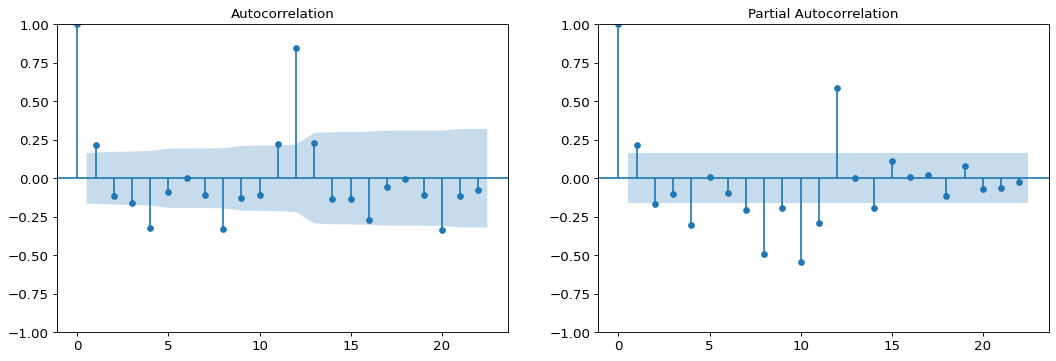

In [3]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Difference the data
data["Passenger_diff"] = data["Passengers_Boxcox"].diff()
data.dropna(inplace=True)

# Plot acf and pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
plot_acf(data['Passenger_diff'], ax=ax1)
plot_pacf(data['Passenger_diff'], ax=ax2, method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

The blue region signifies where the points are no longer statistically significant and from the plot we see the last lag that is statistically significant for both plot is ~12th. Therefore, we would take the order of p and q to be 12.\
\
Now, let’s fit the model using the ARIMA function and generate the forecasts:

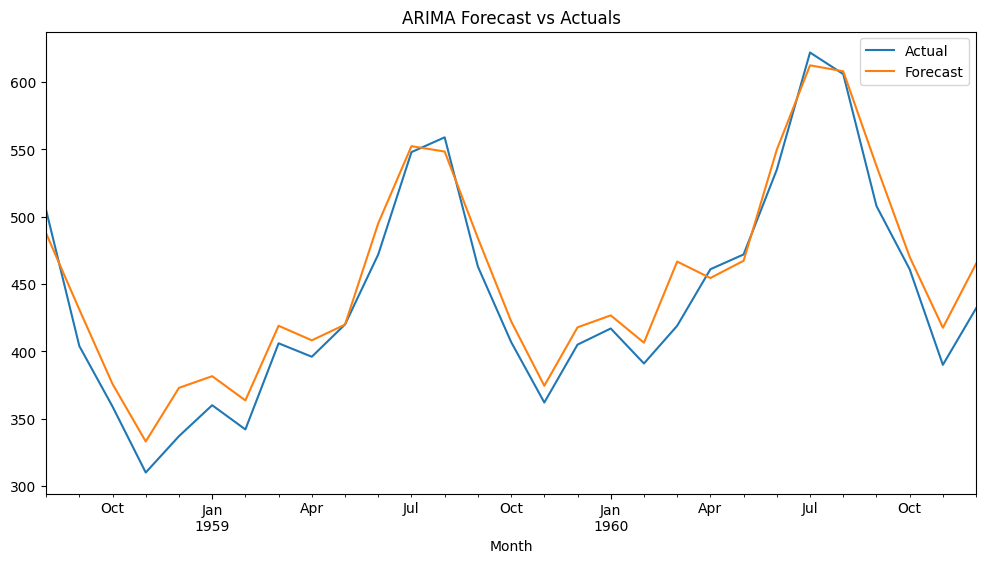

In [4]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import warnings
warnings.filterwarnings("ignore")  # Temporarily suppress warnings

# Load and prepare data
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')

# Apply Box-Cox transformation
data['Passengers_Boxcox'], lam = boxcox(data['#Passengers'])

# Split train and test
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Build simpler ARIMA model (start with basic parameters)
model = ARIMA(train['Passengers_Boxcox'], 
              order=(2, 1, 2),  # Simpler model
              seasonal_order=(1, 1, 1, 12)).fit()  # Add seasonal component

# Generate forecasts
boxcox_forecasts = model.forecast(steps=len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

# Create results DataFrame
results = pd.DataFrame({
    'Actual': test['#Passengers'],
    'Forecast': forecasts
}, index=test.index)

import matplotlib.pyplot as plt
results.plot(figsize=(12,6))
plt.title('ARIMA Forecast vs Actuals')
plt.show()

### Results

The forecasts produced from this fitted model is for the differenced and Box-Cox transformed time series that we produced earlier. Therefore, we have to un-difference and apply the inverse Box-Cox transform to the predictions to acquire the actual airline passenger forecasted volumes:

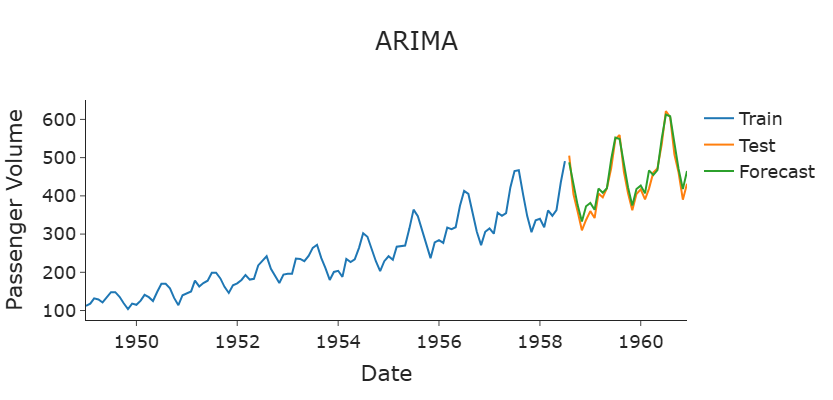

In [5]:
# Import packages
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()

# Plot the forecasts
plot_forecasts(forecasts, 'ARIMA')